In [1]:
#clean notebook for testing 

import numpy as np
import pandas as pd
import sys
import math
import cvxopt
from scipy.linalg import fractional_matrix_power, block_diag
from pylab import *
from cvxpy import *
import argparse
import implicit
from scipy.sparse import csr_matrix
import copy

/Users/bergeric/miniconda3/envs/netrex/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/bergeric/miniconda3/envs/netrex/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/bergeric/miniconda3/envs/netrex/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/bergeric/miniconda3/envs/netrex/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/bergeric/miniconda3/envs/netrex/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96

Make test data:

In [2]:
#build S with blocks on diagonal

#make 3 blocks of diff sized matrices of 1s
bl1 = np.ones((6, 3))
bl2 = np.ones((8, 8))
bl3 = np.ones((10, 4))

S_real = block_diag(bl1, bl2, bl3)
m = S_real.shape[0] #number genes
n = S_real.shape[1] #number tfs

l = 40 #number exp samples

#build A dim n x l (tf x expsamples)
A_real = np.random.rand(n, l)

#build E dim m x l
E_real = S_real.dot(A_real)
E_real.shape

(24, 40)

In [3]:
#build weight matrix C dim m x n from S
C_real = np.random.rand(m, n) * S_real

In [4]:
#build test C -- add noise?
#make 10% from each of the blocks 0.  
blocks = [bl1, bl2, bl3]

for block in blocks: 
    pct = round(block.size * .10)
    for i in range(pct):
        block[1][i] = 0
    np.random.permutation(block)
    
dropped_ten_pct = block_diag(bl1, bl2, bl3)

#build C with 10% of vals in each block dropped
C_test = dropped_ten_pct * C_real

In [5]:
#build parameter matrix lambda_ dim m x n 
lmda_real = np.ones((m, n))

#set theta and alpha to 1

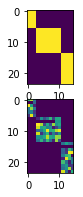

In [6]:
import matplotlib.pyplot as plt

plt.figure(1, figsize=(8, 3))
ax1 = plt.subplot(211)
ax1.imshow(S_real)
ax2 = plt.subplot(212)
ax2.imshow(C_test)
plt.show()

Use test data with netrex class code:

In [7]:
class NetREX: 
    #init
    def __init__(self, E, C, lambda_, theta=1, alpha=1, iternum = 1000, p = 20):
        #parameters
        self.theta = theta # scalar > 0
        self.alpha = alpha
        self.xbound = 1.0
        self.ybound = 1.0
        self.iternum = iternum
        self.lambda_ = lambda_ #parameter matrix
        #read in exp, read prior data 
        #self.ReadExp(ExpFile) #get ExpMat from this
        self.ExpMat = E #expression for now
        self.C = C #matrix of confidences (weights)
        self.NumGene = E.shape[0]
        self.NumTF = C.shape[1]
        self.NumExp = E.shape[1]
        #parameter matrix eta
        self.eta = self.C + theta
        self.i_ = range(self.NumGene) #range of i
        self.j_ = range(self.NumTF) #range of j 
        #set initial S to C
        self.S = copy.deepcopy(C)
        #controls amount of factors in xi/yj
        self.p = p
        
    #Put read in exp here later
    
    #initialization
    def initialization(self):
        #Use implicit package for CF problems to initialize X & Y: 
        implicit_model = implicit.als.AlternatingLeastSquares(factors=self.p)
        #train model on weight matrix C
        implicit_model.fit(csr_matrix(self.C))
        #initial X (matrix of xi vectors)
        self.X = implicit_model.item_factors.T
        #initial Y (matrix of yj vectors)
        self.Y = implicit_model.user_factors.T
        
        plt.figure(1, figsize=(8, 3))
        ax1 = plt.subplot(211)
        ax1.imshow(self.X.T.dot(self.Y))
        plt.show()
        
        #binarize S to use for finding A 
        S_init = (self.S > 0 ).astype(int)
        #initialize A using NetREX 1 closed form
        Abound = 1.0
        Atmp = np.linalg.inv(S_init.T.dot(S_init)+np.eye(self.NumTF)).dot(S_init.T).dot(self.ExpMat)
        self.A = np.multiply((np.absolute(Atmp)<=Abound), Atmp) + \
                                        np.multiply((np.absolute(Atmp)>Abound), np.sign(Atmp)*Abound)
        #initial Uk
        mu_S = np.linalg.norm(self.A.dot(self.A.T), 'fro')
        Uk = self.S - (2./mu_S)*(self.S.dot(self.A).dot(self.A.T) - self.ExpMat.dot(self.A.T))
        #initial S 
        c = np.sqrt((2./mu_S)*(self.alpha*self.lambda_*np.square(np.ones([self.NumGene,self.NumTF]) -
                                                          self.X.T.dot(self.Y)) + self.eta))  
        Sequal = np.where(np.absolute(Uk) == c, c*np.random.randint(2, size=(self.NumGene,self.NumTF)), 0)
        Sgreater = np.where(np.absolute(Uk) > c, Uk, 0)
        self.S = Sequal + Sgreater
        
        plt.figure(1, figsize=(8, 3))
        ax1 = plt.subplot(211)
        ax1.imshow(self.S)
        plt.show()
        
    #Define the objective function 
    def ObjFunction(self):
        S_0 = (self.S != 0).astype(int) 
        self.a_ = self.lambda_*(self.C + self.alpha*S_0)
        W = np.sqrt(self.a_) 
        Val = np.linalg.norm(self.ExpMat - self.S.dot(self.A), 'fro')**2 +np.linalg.norm(W*(S_0 - self.X.T.dot(self.Y)),
                    'fro')**2 + np.linalg.norm(np.sqrt(self.eta*S_0), 'fro')**2
        return Val
    
    def PALM_A(self):
        mu_A = np.linalg.norm(self.S.T.dot(self.S), 'fro')
        #solution for A
        self.A = (np.linalg.inv((2./mu_A)*self.S.T.dot(self.S)+ np.identity(self.NumTF))).dot(((2./mu_A) * 
                                                                self.ExpMat.T.dot(self.S) + self.A.T).T) 
        
    def PALM_S(self):
        mu_S = np.linalg.norm(self.A.dot(self.A.T), 'fro')
        Uk = self.S - (2./mu_S)*(self.S.dot(self.A).dot(self.A.T) - self.ExpMat.dot(self.A.T))
        c = np.sqrt((2./mu_S)*(self.alpha*self.lambda_*np.square(np.ones([self.NumGene,self.NumTF]) -
                                                          self.X.T.dot(self.Y)) + self.eta))
        #solution for S   
        Sequal = np.where(np.absolute(Uk) == c, c*np.random.randint(2, size=(self.NumGene,self.NumTF)), 0)
        Sgreater = np.where(np.absolute(Uk) > c, Uk, 0)
        self.S = Sequal + Sgreater
    
    def solve_qcqp(self, phi, varphi): 
        '''
        Use cvxpy to solve the problem: 
        min x^T*phi*x + varphi*x
        s.t. to norm(x) <= 1
        (problem is the same for y)
        '''
         
        x = Variable(self.p)
        P = phi.astype(np.double) #this is phi modified for cvxpy
        q = varphi.astype(np.double) #unsure abt transpose? varphi modified for cvxpy

        objective = Minimize(quad_form(x,P) + q.T*x)
        constraints = [square(norm(x)) <= 1]
        
        prob = Problem(objective, constraints)
        try:
            result = prob.solve()
            return x.value
        except:
            prob.solve(verbose=True)
           
    def PALM_x(self):
        #define variables for matrix formulation
        for i in self.i_: 
            x = self.X[:,i]
            A_i = np.diag([self.a_[i,j] for j in self.j_])
            S_i = np.array([self.S[i,j] for j in self.j_]) 
            mu_x = np.linalg.norm(2*self.Y.dot(A_i).dot(self.Y.T), 'fro')                            
            phi = (mu_x/2)*np.identity(self.p) + self.Y.dot(A_i).dot(self.Y.T)
            varphi = 2*S_i.dot(A_i).dot(self.Y.T) + mu_x*x.T
            x = self.solve_qcqp(phi, varphi)
            self.X[:,i] = x
    
    def PALM_y(self):
        #matrix formulation
        for j in self.j_:
            y = self.Y[:,j]
            A_j = np.diag([self.a_[i,j] for i in self.i_])
            S_j = np.array([self.S[i,j] for i in self.i_])
            mu_y = np.linalg.norm(2*self.X.dot(A_j).dot(self.X.T), 'fro')
            phi = (mu_y/2)*np.identity(self.p) + self.X.dot(A_j).dot(self.X.T)
            varphi = 2*S_j.T.dot(A_j).dot(self.X.T) + mu_y*y.T
            y = self.solve_qcqp(phi, varphi)
            self.Y[:,j] = y
            
    #algorithm
    def NetREX_algorithm(self):
        self.initialization()
        conv_point = 0.1 #for now?  

        Valold = self.ObjFunction()
        for k in range(self.iternum): 
            self.PALM_A()
            for i in self.i_:
                self.PALM_S()
            self.PALM_x()
            self.PALM_y()
            Valnew = self.ObjFunction()
            check_pt = np.abs(Valold-Valnew)
            if (check_pt < conv_point) :
                print("Converge!")
                sys.stdout.flush()
                break
            Valold = Valnew
        return Valold
        
def main():
        #parser = argparse.ArgumentParser(description='netREX: network rewiring using expression')
        #define arguments
        #requiredArgs = parser.add_argument_group('required arguments')
        #requiredArgs.add_argument('-e', type=str, nargs=1, dest='expfile', required=True, metavar="expression_file",
        #                     default=None, help="<Required> Name of the expression file")
        #requiredArgs.add_argument('-c', type=str, nargs=1, dest='confidences', required=True, 
        #                metavar="confidence_matrix", default=None, help='<Required> File w matrix of confidences')
        #parser.add_argument()
    
        #parse arguments from std input
        #args=parser.parse_args()
    
        #if len(sys.argv)==1:
        #    parser.print_help(sys.stderr)
        #    sys.exit(1)
    
        #if args.expfile == None:
        #    sys.exit('missing expression data file!')
        
        #if args.confidences == None:
        #    sys.exit('missing confidence file!')
    
        #run netrex
        #tmp = NetREX(E_real, C_test, lmda_real)
        #tmp.NetREX_algorithm()
        print("Ready")

if __name__ == '__main__':
    main()

Ready


100%|██████████| 15.0/15 [00:00<00:00, 135.77it/s]


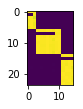

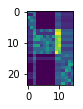

Converge!


560.1041411385088

In [8]:
tmp = NetREX(E_real, C_test, lmda_real)
tmp.NetREX_algorithm()

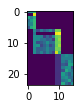

In [9]:
S_test = tmp.S
A_test = tmp.A

plt.figure(1, figsize=(8, 3))
ax1 = plt.subplot(211)
ax1.imshow(tmp.S)
plt.show()